In [12]:
from __future__ import print_function
from __future__ import division

import sys
import os
qprc_path = os.path.abspath(os.path.join('..'))
if qprc_path not in sys.path:
    sys.path.append(qprc_path)
    
from utils.plots import plot_decision_function_kernel, plot_decision_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from  kernelfuzzy.fuzzyset import FuzzySet
from  kernelfuzzy.fuzzification import FuzzyData
from kernelfuzzy.kernels import gram_matrix_KBF_kernel,KBFkernel
from sklearn.datasets.samples_generator import make_classification
from sklearn.datasets import make_moons, make_circles,make_blobs,load_digits
from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

# Training a Non-singleton Fuzzy System with SVM and KBF lernel

This notebook shows a practical implementation of:
* A data fuzzification approaches
* kernel on fuzzy sets estimation via the cross-product kernel in fuzzy sets
* experimental validation with a SVM

## A dataset

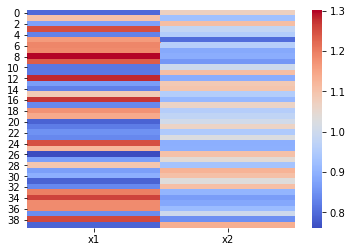

In [13]:
# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)
#X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
#X, y = make_moons(noise=0.3, random_state=0)
#X, y = make_circles(noise=0.2, factor=0.5, random_state=1)

df=pd.DataFrame(data=X,columns=['x1','x2'])
df['y']=y

#nonsingleton fuzzyfication of the dataset
fuzzy_data = FuzzyData(data=df, target='y')
fuzzy_data.non_singleton_fuzzification_classification(constant_std=False)
#printing std values
ax = sns.heatmap(fuzzy_data.get_std_values(), cmap="coolwarm")

## C-SVM solution

//anaconda/envs/fuzzy-kernels/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



support vector indices :[ 3  6  8  9 12 15 16 18 19 35 36  0  2 10 14 21 23 26 27 30 31]
number of support vector per class :[11 10]


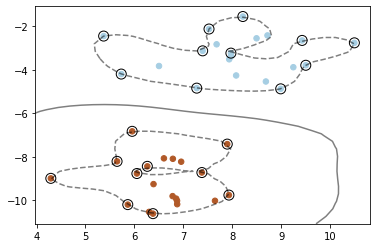

In [14]:

# fit the model, don't regularize for illustration purposes
clf = SVC(C=1000)
clf.fit(X, y)

print("support vector indices :{}".format(clf.support_))
print("number of support vector per class :{}".format(clf.n_support_))
#print("support vectors class 0 :{}".format(clf.support_vectors_[:, 0]))
#print("support vectors class 1 :{}".format(clf.support_vectors_[:, 1]))
#print("dual coefficients : {}".format(clf.dual_coef_))
plot_decision_function(X,y,clf)

## Training a Non-singleton FS with a C-SVM with KBF kernel

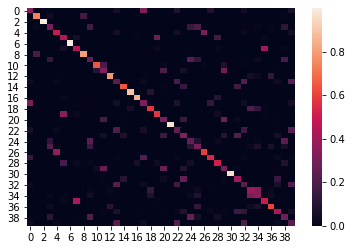

support vector indices :[ 1  3  5  6  7  8  9 12 15 16 18 19 24 25 28 33 34 35 36 38  0  2  4 10
 11 13 14 17 20 21 22 23 26 27 29 30 31 32 37 39]
number of support vector per class :[20 20]
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
(40, 2)


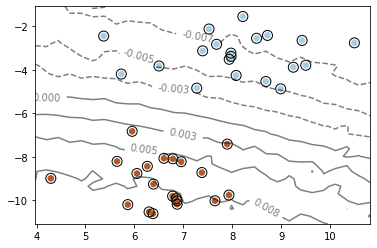

In [15]:
X_train = fuzzy_data.get_fuzzydata()
y_train = fuzzy_data.get_target()

svc_p = SVC(kernel='precomputed',C=0.01)

#training
K = gram_matrix_KBF_kernel(X_train, X_train, 10)

sns.heatmap(K)
plt.show()
svc_p.fit(K,y_train)

print("support vector indices :{}".format(svc_p.support_))
print("number of support vector per class :{}".format(svc_p.n_support_))
#print("support vectors class 0 :{}".format(clf.support_vectors_[:, 0]))
#print("support vectors class 1 :{}".format(clf.support_vectors_[:, 1]))
#print("dual coefficients : {}".format(svc_p.dual_coef_))

print(svc_p)

print(fuzzy_data.get_data().to_numpy()[:,:-1].shape)
#print(fuzzy_data.get_data().to_numpy()[:,:-1])
plot_decision_function_kernel(X,X_train,y_train,svc_p)


## Training a Non-singleton FS with a nu-SVM with KBF kernel and  cross-validation

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


{'KBF__KBF_param': 1e-08, 'svm__kernel': 'precomputed'}
[ 1  3  5  6  7  8  9 12 15 16  0  2  4 10 11 13 14 17 20 21]
[10 10]
[[-55063683.28205128 -55063683.28205128 -55063683.28205128
  -55063683.28205128 -55063683.28205128 -55063683.28205128
  -55063683.28205128 -55063683.28205128 -55063683.28205128
  -55063683.28205128  55063683.28205128  55063683.28205128
   55063683.28205128  55063683.28205128  55063683.28205128
   55063683.28205128  55063683.28205128  55063683.28205128
   55063683.28205128  55063683.28205128]]
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='precomputed', max_iter=-1, nu=0.5, probability=False,
      random_state=None, shrinking=True, tol=0.001, verbose=False)
(40, 2)


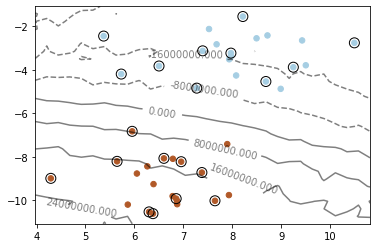

In [19]:
X_train = fuzzy_data.get_fuzzydata()
y_train = fuzzy_data.get_target()

#pipe
nuParam=0.5
pipe = Pipeline([
    ('KBF', KBFkernel()),
    ('svm', NuSVC(nu=nuParam))])

#grid search over KBF kernel parameter   
cv_params = dict([
    ('KBF__KBF_param', 10.0**np.arange(-9,3)),
    ('svm__kernel', ['precomputed'])
    # ('svm__C', 10.0**np.arange(-3,3)),
])

model = GridSearchCV(pipe, cv_params, cv=5, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)
    
#training the model with the best parameters
print(model.best_params_)
best_params=model.best_params_
    
#clf = SVC(kernel='precomputed',C=best_params['svm__C'])
clf = NuSVC(kernel='precomputed',nu=nuParam)
K = gram_matrix_KBF_kernel(X_train, X_train, best_params['KBF__KBF_param'])
clf.fit(K, y_train)

print(clf.support_)
print(clf.n_support_)
print(clf.dual_coef_)
print(clf)

print(fuzzy_data.get_data().to_numpy()[:,:-1].shape)
plot_decision_function_kernel(X,X_train,y_train,clf)